In [40]:
%matplotlib inline
import numpy as np
import os, sys
import cv2
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from torch.utils import data

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from data import goes16s3


import matplotlib
params = {
   'axes.labelsize': 14,
   #'text.fontsize': 8,
    'axes.titlesize': 16,
   'legend.fontsize': 14,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [7, 4] # instead of 4.5, 4.5
   }
matplotlib.rcParams.update(params)

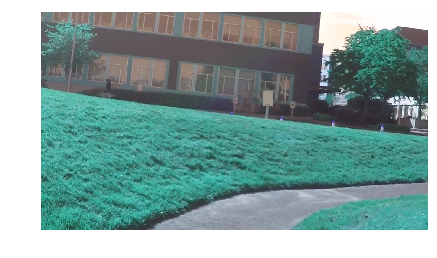

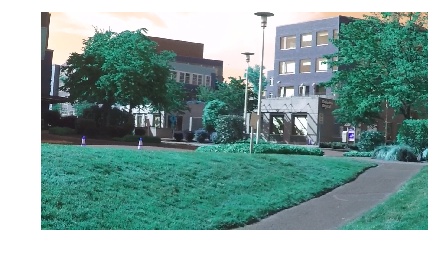

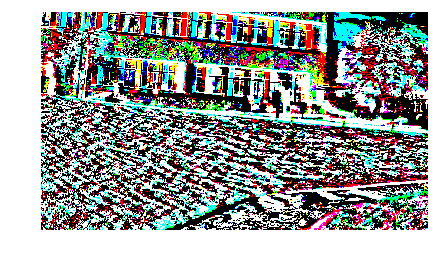

In [41]:
def video_frame_differences(video_file, skip_n=5):
    vidcap = cv2.VideoCapture(video_file)
    success,image1 = vidcap.read()
    image1 = np.float32(image1)
    count = 1
    prev_frame = image1
    diffs = []
    while success:
        success, image = vidcap.read()
        image = np.float32(image)
        if success and (count % skip_n == 0):
            if prev_frame is not None:
                diffs.append((image - prev_frame)[np.newaxis])
            prev_frame = image
        count += 1
        
    plt.imshow(image1 / 255.)
    plt.axis('off')
    plt.show()

    plt.imshow(prev_frame / 255.)
    plt.axis('off')
    plt.show()
    
    return np.concatenate(diffs, 0)

video_file = '/raid/tj/adobe240fps/original_high_fps_videos/GOPR9655a.mp4'
video_errors = video_frame_differences(video_file, 9)


plt.imshow(video_errors[3])
plt.axis('off')
plt.show()

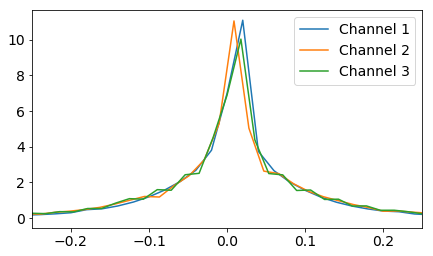

In [42]:
for j in range(video_errors.shape[3]):
    counts, bins = np.histogram(video_errors[:,:,:,j].flatten()/255., bins=100, density=True)
    plt.plot(bins[1:], counts, label='Channel {}'.format(j+1))
    
plt.xlim([-0.25,0.25])
plt.legend()
plt.show()

In [43]:
#noaa = goes16s3.NOAAGOESS3(channels=range(1, 4), product='ABI-L1b-RadC', 
#                           save_directory='/mnt/nexai-goes/GOES/S3/')
noaa = goes16s3.NOAAGOESS3(channels=range(1, 9), product='ABI-L1b-RadM', 
                           save_directory='/mnt/nexai-goes/GOES/S3/')

In [44]:
#iterator = noaa.iterate_day(2018, 313, hours=range(18,23), 
#                           min_queue_size=0, max_queue_size=2,
#                           normalize=True)
iterator = noaa.iterate_day(2017, 71, hours=range(16,23), 
                            min_queue_size=0, max_queue_size=15,
                            normalize=True)
diffs = []
for frame in iterator:
    diffs.append((frame.values[-1] - frame.values[0])[np.newaxis])
    if len(diffs) > 2:
        break
errors = np.concatenate(diffs, 0)

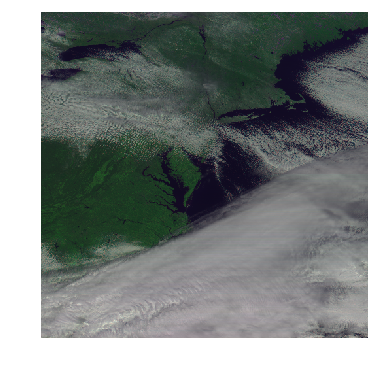

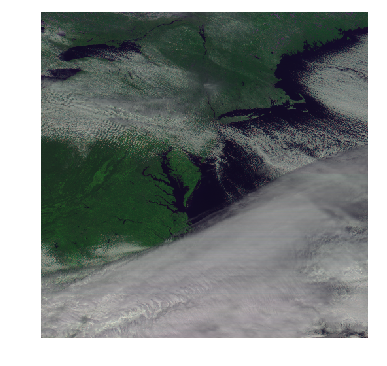

(1, 500, 500)


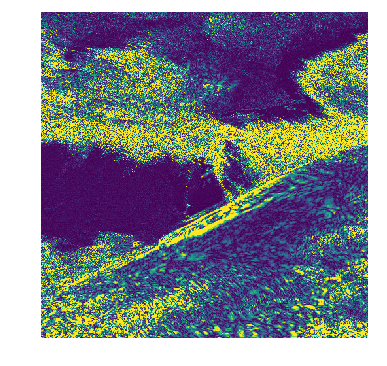

In [45]:
arr = frame.values[0,[1,2,0]]
arr = np.transpose(arr, (1,2,0))
plt.figure(figsize=(6,6))
plt.imshow(arr)
plt.axis('off')
plt.show()

arr = frame.values[8,[1,2,0]]
arr = np.transpose(arr, (1,2,0))
plt.figure(figsize=(6,6))
plt.imshow(arr)
plt.axis('off')
plt.show()


arr = frame.values[8,[0]] - frame.values[0,[0]]
print(arr.shape)
#arr = np.transpose(arr, (1,2,0))
plt.figure(figsize=(6,6))
plt.imshow(np.squeeze(np.abs(arr)), vmin=0, vmax=0.05)
plt.axis('off')
plt.show()



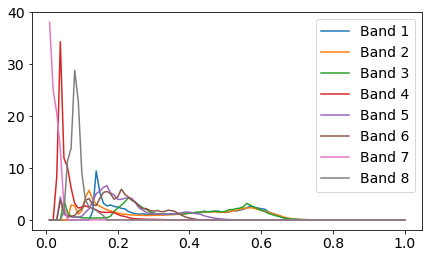

In [46]:
for j in range(frame.shape[1]):
    counts, bins = np.histogram(frame.values[:,j].flatten(), bins=100, 
                                density=True, range=[0,1])
    plt.plot(bins[1:], counts, label='Band {}'.format(j+1))
plt.legend()
plt.show()

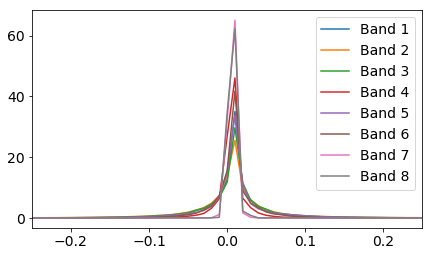

In [47]:
for j in range(errors.shape[1]):
    counts, bins = np.histogram(errors[:,j].flatten(), bins=100, 
                                        density=True, range=[-0.5,0.5])
    plt.plot(bins[1:], counts, label='Band {}'.format(j+1))
plt.xlim([-0.25,0.25])

plt.legend()
plt.show()

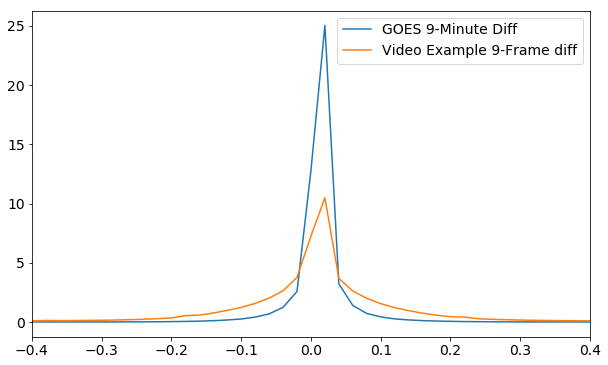

In [48]:
#for j in range(errors.shape[1]):
plt.figure(figsize=(10,6))
counts, bins = np.histogram(errors.flatten(), bins=50, 
                            density=True, range=[-0.5,0.5])
plt.plot(bins[1:], counts, label='GOES 9-Minute Diff'.format(j+1))

counts, bins = np.histogram((video_errors/255.).flatten(), bins=50, 
                            density=True, range=[-0.5,0.5])
plt.plot(bins[1:], counts, label='Video Example 9-Frame diff'.format(j+1))

plt.xlim([-0.4,0.4])
plt.legend()
plt.show()

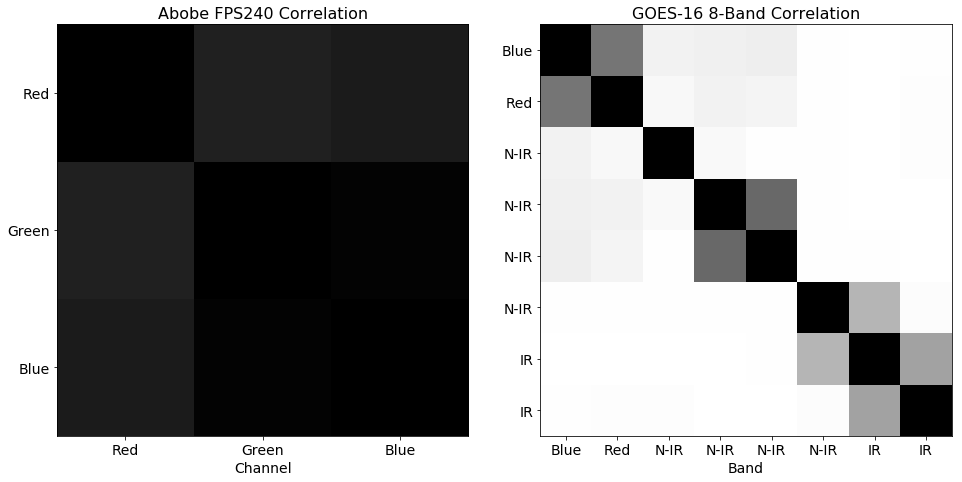

In [58]:
fig, axs = plt.subplots(1,2,figsize=(14,8))
axs = np.ravel(axs)

errorst = np.transpose(errors, (1,0,2,3))
errorst = errors.reshape([errorst.shape[0], -1], order='A')
corrs = pd.DataFrame(errorst.transpose()).corr()


im = axs[1].imshow(np.abs(corrs.values)[::-1], 
                   cmap='Greys', vmin=0, 
                   vmax=1., extent=(0.5,8.5,0.5,8.5))
axs[1].set_title("GOES-16 8-Band Correlation")
axs[1].set_xlabel("Band")
axs[1].set_xticks(range(1,9))
axs[1].set_yticks(range(1,9))
axs[1].set_xticklabels(['Blue', 'Red', 'N-IR', 'N-IR', 'N-IR', 'N-IR', 'IR','IR'])
axs[1].set_yticklabels(['Blue', 'Red', 'N-IR', 'N-IR', 'N-IR', 'N-IR', 'IR','IR'])
axs[1].invert_yaxis()

verr = np.transpose(video_errors, (3,0,1,2))
verr = verr.reshape([verr.shape[0], -1], order='A')
vcorrs = pd.DataFrame(verr.transpose()).corr()
axs[0].imshow(np.abs(vcorrs.values[::-1]), 
              cmap='Greys', vmin=0, vmax=1., 
              extent=(0.5, 3.5, 0.5, 3.5))
axs[0].set_title("Abobe FPS240 Correlation")
axs[0].set_xticks(range(1,4))
axs[0].set_yticks(range(1,4))
axs[0].set_xticklabels(['Red', 'Green', 'Blue'])
axs[0].set_yticklabels(['Red', 'Green', 'Blue'])
axs[0].invert_yaxis()

axs[0].set_xlabel("Channel")

#plt.colorbar(im, ax=axs[0], shrink=0.8)
#plt.colorbar(im, ax=axs[1], shrink=0.8)
plt.tight_layout(pad=3.)
plt.savefig("figures/data-correlation.png", dpi=200)
plt.show()

## Training Data

In [26]:
data_params = {'batch_size': 1000, 'shuffle': True}
dataset = goes16s3.GOESDataset(example_directory='/raid/tj/GOES/SloMo/9Min-3Channels-Train/',
                               n_upsample=9,
                               n_overlap=3)
data_generator = data.DataLoader(dataset, **data_params)

In [27]:
for i, (I0, I1, IT) in enumerate(data_generator):
    diff = I1 - I0
    print(diff.shape)
    break

torch.Size([1000, 3, 128, 128])


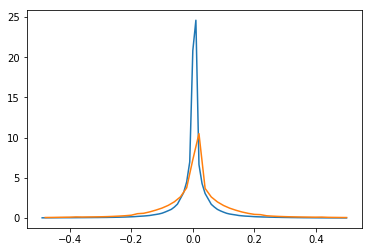

In [28]:
counts, bins = np.histogram(diff.flatten(), bins=100, 
                            density=True, range=[-0.5,0.5])
plt.plot(bins[1:], counts, label='Random Set of GOES Examples')

counts, bins = np.histogram((video_errors/255.).flatten(), bins=50, 
                            density=True, range=[-0.5,0.5])
plt.plot(bins[1:], counts, label='Video Example 9-Frame diff')


plt.show()